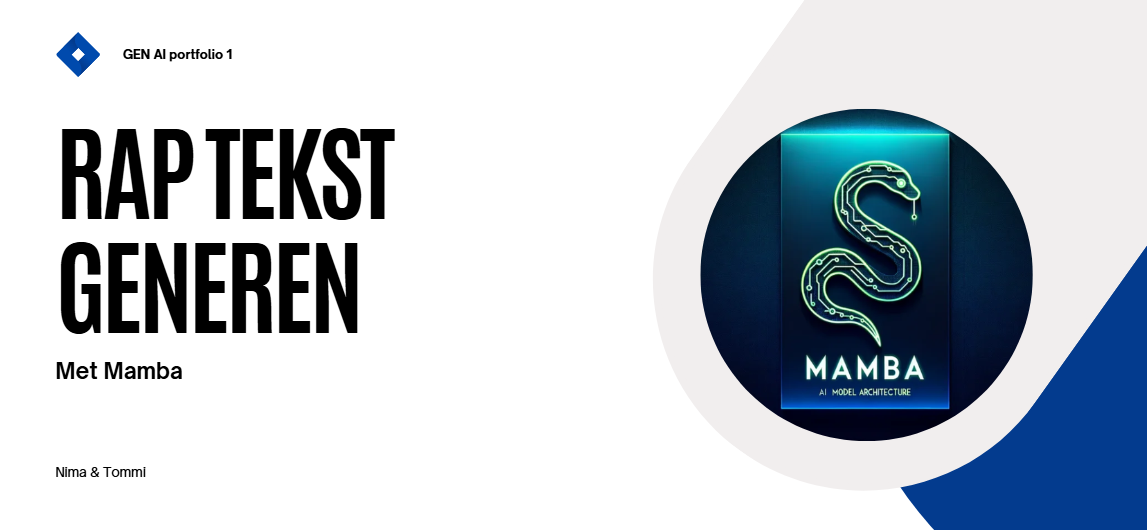


---
<div style="background-color:lightblue; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Inhoudsopgave </strong></h2>
</div>


**H1: Het Project**
- Projectbeschrijving en doelstelling

**H2: Data verzamelen & voorbereiding**
- Dataset selectie en inlading
- Data preprocessing en tokenization

**H3: Methodologie**
- Mamba Model Implementatie met HiPPO

**H4: Training**
- Training setup en optimalisatie

**H5: Resultaten & Evaluatie**
- Training performance
- Text generation voorbeelden

**H6: Conclusie**
- Bevindingen en interpretatie

**H7: Bronnen**


---
<div style="background-color:lightblue; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> H1: Het Project </strong></h2>
</div>


#### **Doelstelling**
In dit project richten we ons op de implementatie van een "Mamba" model. Dit is een sequence modeling framework wat is gebaseerd op "Selective State Space Models". Traditionele language models zoals transformers zijn erg effectief voor tekstgeneratie, maar hebben moeite met lange sequenties. Volgens de Paper: "Mamba: Linear-Time Sequence Modeling with Selective State Spaces" biedt Mamba een veelbelovend alternatief. Dit project heeft als hoofddoel om een Mamba-model te implementeren met HiPPO initialisatie en dit vervolgens te evalueren op het genereren van raps. 

#### **Dataset**
We hebben een dataset gekozen die veel rapteksten bevat :
- **Rijm structuren** : Rap heeft lastige rijm patronen die lastig kunnen zijn voor language models. 
- **Creativiteit** : Rap bevat veel woordspelingen en creatief taalgebruik.
- **Lange context** : Raps hebben vaak een langere context. 
*https://www.kaggle.com/datasets/jamiewelsh2/rap-lyrics.*

#### **Mamba & HiPPO**
Waarom is Mamba met HiPPO nou zo geschikt voor deze taak:
- **Selective attention**: Er zijn selectieve mechanismen die zich kunnen aanpassen aan de importance van tokens, wat belangrijk is voor het begrijpen van complexe woordspelling. 
- **Lange-termijn geheugen**: HiPPO (High-order Polynomial Projection Operators) matrices bieden een manier om lange sequenties te kunnen onthouden, wat belangrijk is voor het behouden van samenhang van de tekst.
- **State Spaces**: De continuteit van een SSM past goed bij rap muziek.


---
<div style="background-color:lightblue; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> H2: Data verzamelen & voorbereiding </strong></h2>

</ul>

**Imports**

In [1]:
import numpy as np
import pandas as pd
import math
import kagglehub
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

**Inladen Dataset**

In [2]:
path = kagglehub.dataset_download("jamiewelsh2/rap-lyrics") # Dataset van Kaggle downloaden: https://www.kaggle.com/datasets/jamiewelsh2/rap-lyrics.
#path = "d:/HHS/GENAI/Project/Mamba"
print("Path to dataset files:", path)


# Dataset inladen
df = pd.read_csv(path + "/updated_rappers.csv")
display(df.head())

Path to dataset files: C:\Users\lande\.cache\kagglehub\datasets\jamiewelsh2\rap-lyrics\versions\1


,Unnamed: 0,artist,song,lyric,next lyric
0,0,Fetty Wap,Trap Queen,rgf productions,remy boyz yahah
1,0,Fetty Wap,Trap Queen,remy boyz yahah,1738 ayy
2,0,Fetty Wap,Trap Queen,1738 ayy,im like hey whats up hello
3,0,Fetty Wap,Trap Queen,im like hey whats up hello,seen yo pretty ass soon as you came in the door
4,0,Fetty Wap,Trap Queen,seen yo pretty ass soon as you came in the door,i just wanna chill got a sack for us to roll


**Kolommen verwijderen**

In [3]:
# Data inladen
def load_data(path):
    """
    Laadt een CSV-bestand met raplyrics en verwijdert lege waarden.

    Parameters:
    path (str): Het pad naar de map met het CSV-bestand.

    Returns:
    pd.DataFrame: Een dataframe met twee kolommen: 'lyric' en 'next lyric'.
    """
    df = pd.read_csv(path + "/updated_rappers.csv")
    df = df[['lyric', 'next lyric']].dropna()
    return df

df = load_data(path)
display(df.head())

,lyric,next lyric
0,rgf productions,remy boyz yahah
1,remy boyz yahah,1738 ayy
2,1738 ayy,im like hey whats up hello
3,im like hey whats up hello,seen yo pretty ass soon as you came in the door
4,seen yo pretty ass soon as you came in the door,i just wanna chill got a sack for us to roll


**Data Preprocessing Functies**

`preprocess_text(text)`

Deze functie is de kern van onze data preprocessing pipeline en transformeert de rap lyrics naar numerieke waardes die ons Mamba-model kan verwerken. Het begint met tokenisatie, waarbij de tekst eerst wordt omgezet naar lowercase met `text.lower().split()` voor consistentie. Vervolgens wordt het opgesplitst in individuele woorden op basis van spaties.

Na de tokenisatie maken we een vocabulaire door alle unieke woorden te verzamelen en alfabetisch te sorteren via `sorted(set(words))`. Dit geeft ons een stabiele en reproduceerbare woordenlijst. Vervolgens maken we twee mappings: een word-to-index dictionary `word2idx = {word: i for i, word in enumerate(vocab)}` die voor elk woord een uniek ID toewijst, en de omgekeerde mapping `idx2word = {i: word for i, word in enumerate(vocab)}` die belangrijk is voor tekstgeneratie.

Ten slotte veranderen we alle woorden in de originele tekst naar hun numerieke indices met `np.array([word2idx[word] for word in words])`, wat ons een numpy array van integers geeft. De functie retourneert drie components: de numerieke tokens, en beide mapping dictionaries die essentieel zijn voor het hele training proces.

`create_batches(tokens, batch_size, seq_length)`

Deze functie implementeert een sliding window om onze tokenized data op te delen in training batches die geschikt zijn voor sequence modeling. Het begint met het berekenen van het maximum aantal batches dat mogelijk is gegeven onze data via `n_batches = len(tokens) // (batch_size * seq_length)`. Om ervoor te zorgen dat alle data perfect in onze batch structuur past, verwijderen we extra tokens.

De tokens worden vervolgens gestructureerd naar een matrix vorm met `tokens.reshape((batch_size, -1))`, wat ons een 2D array geeft waar elke rij een andere sequence in de batch representeert. Het belangrijke van de functie is de sliding window loop die over de data beweegt met stappen van `seq_length`. Voor elke positie `i` krijgen we een input sequence `x_batch = x[:, i:i+seq_length]` en het bijbehorende target `y_batch = x[:, i+1:i+seq_length+1]`. 

Deze target sequence is één positie verschoven ten opzichte van de input, wat het principe van next-token prediction implementeert. Door deze aanpak kunnen we efficiënt door grote datasets itereren zonder alle data tegelijk in het geheugen te laden, wat essentieel is voor het trainen van language models op uitgebreide rap lyrics datasets.

In [4]:
def preprocess_text(text):
    """
    Zet tekst om in een lijst van unieke woorden en maakt een woordenboek met bijbehorende nummers.

    Parameters:
    text (str): De invoertekst die wordt omgezet.

    Returns:
    tuple: 
        - tokens (np.array): Een lijst van getallen die de woorden in de tekst vertegenwoordigen.
        - word2idx (dict): Een woordenboek dat elk woord een uniek nummer geeft.
        - idx2word (dict): Een omgekeerd woordenboek dat elk nummer terugvertaalt naar het bijbehorende woord.
    """
    words = text.lower().split()
    vocab = sorted(set(words))
    word2idx = {word: i for i, word in enumerate(vocab)}
    idx2word = {i: word for i, word in enumerate(vocab)}
    tokens = np.array([word2idx[word] for word in words], dtype=np.int32)
    return tokens, word2idx, idx2word

def create_batches(tokens, batch_size, seq_length):
    """
    Verdeelt de tokens in kleine stukjes (batches) om het model te trainen.

    Parameters:
    tokens (np.array): De lijst met getallen die de woorden in de tekst vertegenwoordigen.
    batch_size (int): Hoeveel voorbeeldzinnen per batch worden gebruikt.
    seq_length (int): De lengte van elke trainingsreeks.

    Returns:
    generator: Geeft bij elke oproep een nieuwe batch van input- en outputgegevens terug.
    """
    n_batches = len(tokens) // (batch_size * seq_length)
    tokens = tokens[:n_batches * batch_size * seq_length]
    x = tokens.reshape((batch_size, -1))
    for i in range(0, x.shape[1] - seq_length, seq_length):
        x_batch = x[:, i:i+seq_length]
        y_batch = x[:, i+1:i+seq_length+1]
        yield x_batch, y_batch


---
<div style="background-color:lightblue; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> H3: Methodologie </strong></h2>

</ul>

#### **Def(`__init__`)**

Voordat het model kan werken, moeten we eerst de onderdelen ervan definiëren. Dit gebeurt in de `__init__`-functie.

Eerst beginnen we met de `self.embedding`-laag. Deze laag is een soort woordenboek dat elk woord (token) omzet in een reeks getallen die het model kan begrijpen. Dit is een belangrijke eerste stap in elk taalmodel.

Zodra een woord is omgezet in getallen, wordt het door de input-projectielagen (`self.in_proj_W` en `self.in_proj_b`) gestuurd. Deze lagen zijn een onderdeel van Mamba. Ze splitsen de input op in twee stromen, genaamd `x` en `z`, een proces dat visueel wordt weergegeven in Figuur 3 van de paper. De `z`-stroom is  een "poort" die later de output zal reguleren, en maakt hiervoor gebruik van de `SiLU`-activatiefunctie.

Nu komen we bij de kern van Mamba: de state space-parameters. Het SSM is geïnspireerd op een continue vergelijking, $h'(t) = Ah(t) + Bx(t)$. De `self.A_log`-parameter in de code vertegenwoordigt de `A`-matrix, die de "state transition" van het geheugen bepaalt. Voor maximale efficiëntie heeft deze matrix een diagonale structuur. De initialisatie ervan is geïnspireerd op de HIPPO-theorie, een wiskundig concept dat het model helpt om afhankelijkheden over zeer lange afstanden te onthouden.

Mamba maakt gebruik van een **selectiemechanisme**. Dit mechanisme wordt geïmplementeerd via de `self.dt_proj_W`, `self.dt_proj_b` en `self.B_proj` lagen. In plaats van vaste regels te hebben, leert Mamba om de parameters `Δ` (delta) en `B` dynamisch aan te passen op basis van de input `x_t`. Dit is de kern van de selectiviteit. De `Δ`-parameter, berekend door de `dt`-lagen, regelt de balans tussen het vasthouden van de oude memorystate en het focussen op de nieuwe input. De `B`-parameter, berekend door `B_proj`, bepaalt op zijn beurt hoeveel van de huidige input `x_t` wordt "geschreven" naar de memorystate `h_t`. 

De `self.C_proj`-laag leest vervolgens de informatie uit de memorystate `h` om een output te maken. Om de training stabiel te houden, wordt een `self.layernorm`-laag gebruikt. Ten slotte wordt de verwerkte informatie door de laatste projectielagen (`self.out_proj_W` en `self.out_proj_b`) gestuurd om de uiteindelijke voorspelling te doen, een stap die ook te zien is in het Mamba-blok in Figuur 3.

#### **Def `__call__`**

Nu we de __init__ hebben gemaakt , beschrijft de `__call__`-functie hoe de data daadwerkelijk door het model stroomt. Dit gebeurt stap voor stap (recurrent) in een `for`-loop die elke input uit de sequentie een voor een verwerkt. Deze recurrente modus, die zeer efficiënt is bij het genereren van nieuwe tekst (*inference*), is een van de twee manieren waarop een SSM kan worden berekend.

Binnen de loop zijn twee belangrijke stappen uit de SSM-theorie:
1. Het model zet eerst de "continue" parameters (`Δ`, `A`, `B`) om naar "discrete" parameters (`Ā`, `B̄`) die per tijdstap werken. Dit proces wordt beschreven in de paper, met de *Zero-Order Hold* (ZOH) (Formule (4)). De code implementeert een vereenvoudigde versie hiervan.
2. Vervolgens wordt het geheugen van het model geüpdatet. De nieuwe staat `h_t` wordt berekend op basis van de vorige staat `h_{t-1}` en de huidige input `x_t`. Dit gebeurt exact volgens de recurrentieformule uit het paper: $h_t = \overline{A}h_{t-1} + \overline{B}x_t$.

Direct nadat de staat is geüpdatet, wordt de output voor die tijdstap, `y_t`, berekend. Dit gebeurt door de nieuwe memorystate `h_t` te projecteren met behulp van de `C`-matrix, wat precies overeenkomt met formule (2b) uit het paper: $y_t = Ch_t$.

Nadat het de hele sequentie heeft verwerkt, worden de outputs van elke stap samengevoegd. Nu komt de `z`-stroom, die we aan het begin hadden afgesplitst, weer in beeld. De output `y` wordt vermenigvuldigd met `z`, wat functioneert als een laatste "poort" die de output moduleert. Deze "multiplication" stap is een belangrijk onderdeel van de Mamba-architectuur (zie Figuur 3) en maakt gebruik van de `SiLU`-activatie. Uiteindelijk wordt dit resultaat door de allerlaatste laag gestuurd om de laatste voorspellingen voor de volgende woorden te genereren.

In [6]:
class Mamba(tf.Module):
    def __init__(self, vocab_size, embed_dim, state_dim, name=None):
        """
        Mamba-model: een lineair sequentiemodel met selectief state-space mechanisme.

        Args:
            vocab_size (int): Grootte van de woordenschat.
            embed_dim (int): Dimensie van de token-embeddings.
            state_dim (int): Dimensie van de interne staat h.
            name (str, optional): Naam van het tf.Module.
        """
        super(Mamba, self).__init__(name=name)

        # Input Embedder: zet tokens om naar vectoren
        self.embedding = tf.Variable(
            tf.random.uniform([vocab_size, embed_dim], -0.1, 0.1),
            name="embedding")

        # In-projectie: transformeert embedding naar twee delen (x en z) met bias
        self.in_proj_W = tf.Variable(
            tf.random.uniform([embed_dim, 2 * embed_dim]),
            name="in_proj_W")
        
        self.in_proj_b = tf.Variable(
            tf.zeros([2 * embed_dim]),
            name="in_proj_b")

        # SSM parameters (HIPPO)
        A = np.arange(1, state_dim + 1, dtype=np.float32)
        self.A_log = tf.Variable(
            tf.math.log(A),
            name="A_log",
            trainable=True)
        
        # D_proj voor residuele verbinding van input naar staat
        self.D_proj = tf.Variable(
            tf.random.uniform([embed_dim, state_dim]),
            name="D_proj")

        # Projecties voor selectiemechanismen
        self.dt_proj_W = tf.Variable(
            tf.random.uniform([embed_dim, state_dim]),
            name="dt_proj_W")
        
        self.dt_proj_b = tf.Variable(
            tf.zeros([state_dim]),
            name="dt_proj_b")
        
        self.B_proj = tf.Variable(
            tf.random.uniform([embed_dim, state_dim]),
            name="B_proj")
        
        # Statische C_proj: voor projection state -> embed_dim
        self.C_proj = tf.Variable(
            tf.random.uniform([state_dim, embed_dim]),
            name="C_proj")

        # LayerNorm voor stabiliteit
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-5)

        # Output-projectie: van interne representatie naar vocab-logits met bias
        self.out_proj_W = tf.Variable(
            tf.random.uniform([embed_dim, vocab_size]),
            name="out_proj_W")
        
        self.out_proj_b = tf.Variable(
            tf.zeros([vocab_size]),
            name="out_proj_b")
        
        self.conv1d = tf.keras.layers.Conv1D(filters=embed_dim, kernel_size=3, padding='same', activation='relu')


    def __call__(self, inputs, initial_state=None):
        batch_size, seq_length = tf.shape(inputs)[0], tf.shape(inputs)[1]
        x_embed = tf.nn.embedding_lookup(self.embedding, inputs)
        x_embed = self.conv1d(x_embed)  


        # Projecteer naar x (SSM-update) en z (output-gate)
        xz = tf.matmul(x_embed, self.in_proj_W) + self.in_proj_b
        x, z = tf.split(xz, 2, axis=-1)

        # Initialiseer interne staat h
        if initial_state is None:
            h = tf.zeros([batch_size, self.A_log.shape[0]], dtype=tf.float32)
        else:
            h = initial_state

        outputs = []
        A = -tf.exp(self.A_log)

        for t in range(seq_length):
            x_t = x[:, t, :]

            delta = tf.nn.softplus(
                tf.matmul(x_t, self.dt_proj_W) + self.dt_proj_b
            )
            B = tf.matmul(x_t, self.B_proj)
            D_term = tf.matmul(x_t, self.D_proj)

            delta_A = delta * A
            delta_B = delta * B

            A_bar = tf.exp(delta_A)
            B_bar_x = delta_B

            # Update interne staat met residu
            h = A_bar * h + B_bar_x + D_term

            # Output-projectie via statische C_proj
            y_t = tf.matmul(h, self.C_proj)
            outputs.append(y_t)

        y = tf.stack(outputs, axis=1)
        y = self.layernorm(y)
        y = y * tf.nn.silu(z)
        logits = tf.matmul(y, self.out_proj_W) + self.out_proj_b

        return logits, h

#Bronnen: 

#(GeeksforGeeks, 2021)
#(What Does tf.nn.embedding_lookup Function Do?, n.d.)
#(Introduction to Variables, n.d.)
#(tf.zeros, n.d.)
#(tf.random.categorical, n.d.)
#(Maartengrootdorst), n.d.https://www.maartengrootendorst.com/blog/mamba/
#(ChatGPT, Maart 2025 - Prompt 1: Hoe zou jij een mamba... https://chatgpt.com/share/67df010c-c968-8013-8bbc-f9f92fe51fa1), 
#(ChatGPT, Maart 2025 - Prompt 2: Ik wil dat je in de class functie... https://chatgpt.com/share/67df010c-c968-8013-8bbc-f9f92fe51fa1)
#(ChatGPT, June 28 - Prompt 3: Wordt hier HiPPO gebruikt... https://chatgpt.com/share/685fe1bf-83c4-8013-bb03-b9535fdb6772)

### **Functie: `__init__(self, vocab_size, embed_dim, state_dim, name=None)`**

Deze functie initialiseert de bouwstenen van het Mamba-model. Dit zijn de onderdelen van het netwerk die later met data gevuld zullen worden.

**`self.embedding`**
* **Code:** Een matrix die elk woord (token) in de `vocab_size` omzet naar een getallenreeks (`embed_dim`).
* **Paper-connectie:** Dit is een standaard onderdeel van elk "sequence model" en wordt niet specifiek in detail behandeld in de Mamba-paper, maar het is de fundamentele eerste stap om tekst te verwerken. 

**`self.in_proj_W` en `self.in_proj_b`**
* **Code:** Deze lagen projecteren de input `x_embed` naar een twee keer zo grote ruimte, die vervolgens wordt opgesplitst in `x` en `z`.
* **Paper-connectie:** Dit is onderdeel van het "Mamba block" ontwerp. Het `z` deel functioneert als een poort (gate) en maakt gebruik van de `SiLU / Swish` activatiefunctie. Dit wordt geïllustreerd in Figuur 3, waar de input wordt opgesplitst. 

**`self.A_log`**
* **Code:** Initialiseert de `A` parameter van de state space model in de log-ruimte. De initialisatie met `np.arange` is een vereenvoudigde versie van de HIPPO-initialisatie.
* **Paper-connectie:** De `A` matrix is een kernonderdeel van de SSM en bepaalt de "state transition". De paper vermeldt dat de `A`-matrix een diagonale structuur heeft voor efficiëntie. De initialisatie is geïnspireerd op de HIPPO-theorie, die helpt bij het onthouden van lange-termijn afhankelijkheden. De specifieke `S4D-Real` initialisatie `-(n+1)` is een van de besproken opties. 

**`self.D_proj`**
* **Code:** Een projectie voor de `D` parameter, die een directe "skip connection" van de input naar de output mogelijk maakt.
* **Paper-connectie:** Hoewel de paper zich focust op de selectiviteit van `Δ`, `B`, en `C`, is de `D` parameter een standaard onderdeel van state space modellen. In de Mamba-architectuur wordt dit een "residual connection" genoemd, wat helpt tegen het verdwijnen van gradiënten.

**`self.dt_proj_W` en `self.dt_proj_b`**
* **Code:** Deze lagen berekenen `Δ` (delta), een belangrijke parameter die afhankelijk is van de input `x_t`.
* **Paper-connectie:** Dit is het **selectiemechanisme**. Door `Δ` afhankelijk te maken van de input, kan het model de "tijdsstap" aanpassen en zo informatie onthouden of negeren. Dit is de belangrijkste toevoeging van Mamba. `Δ` regelt de balans tussen het onthouden van de huidige staat en het focussen op de nieuwe input.

**`self.B_proj`**
* **Code:** Deze laag maakt de `B` parameter van de SSM afhankelijk van de input.
* **Paper-connectie:** Net als `Δ`, wordt `B` selectief gemaakt om de invloed van de huidige input `x_t` op de verborgen staat `h_t` te kunnen sturen. 

**`self.C_proj`**
* **Code:** Deze laag doet de verborgen staat `h` terug naar de output. 
* **Paper-connectie:** De `C` parameter bepaalt hoe de verborgen staat wordt omgezet in de uiteindelijke output. De paper beschrijft dat ook `C` selectief gemaakt kan worden. 

**`self.layernorm`**
* **Code:** Een standaard `LayerNormalization` laag.
* **Paper-connectie:** De Mamba-architectuur gebruikt normalisatielagen, vergelijkbaar met Transformers, voor stabielere training. 

**`self.out_proj_W` en `self.out_proj_b`**
* **Code:** De laatste laag die de interne representatie omzet naar voorspellingen voor de `vocab_size`.
* **Paper-connectie:** Dit is de output die te zien is in het Mamba-blok in Figuur 3. 

---

### **Functie: `__call__(self, inputs, initial_state=None)`**

Deze functie beschrijft hoe de data door de geïnitialiseerde lagen stroomt ("forward pass").

**`x, z = tf.split(...)`**
* **Code:** Splitst de input in `x` (voor de SSM) en `z` (voor de output gate).
* **Paper-connectie:** Dit komt direct overeen met de architectuur in Figuur 3, waar de input twee paden volgt. 

**`for t in range(seq_length):`**
* **Code:** De lus die elke tijdstap van de sequentie één voor één verwerkt.
* **Paper-connectie:** Dit is de recurrent mode van de SSM, beschreven in formule (2a) en (2b). Deze modus is efficiënt tijdens het genereren van nieuwe teksten. 

**`delta = tf.nn.softplus(...)`**, **`B = ...`**, **`D_term = ...`**
* **Code:** Hier worden de selectieve parameters `Δ`, `B` en `D` voor elke tijdstap `t` berekend op basis van de input `x_t`.
* **Paper-connectie:** Dit is de kern van het selectiemechanisme, zoals beschreven in 3.2. De Softplus-functie zorgt ervoor dat `Δ` positief blijft.

**`A_bar = tf.exp(delta_A)`**, **`B_bar_x = delta_B`**
* **Code:** De continue parameters (`A`, `B`) worden omgezet naar discrete parameters (`Ā`, `B̄`).
* **Paper-connectie:** Dit proces wordt "Discretization" genoemd en is beschreven in Sectie 2 (𝑨 = exp(Δ𝑨) ). De code gebruikt een vereenvoudigde versie van de Zero-Order Hold (ZOH) discretisatieformule (4). 

**`h = A_bar * h + B_bar_x + D_term`**
* **Code:** De update van de verborgen staat `h`.
* **Paper-connectie:** Dit is de recurrente update, exact zoals in formule (2a): $h_t = \overline{A}h_{t-1} + \overline{B}x_t$.De `D_term` is hier een extra residuele connectie.

**`y_t = tf.matmul(h, self.C_proj)`**
* **Code:** De output `y_t` wordt berekend op basis van de nieuwe staat `h_t`.
* **Paper-connectie:** Dit komt overeen met formule (2b): $y_t = Ch_t$. 

**`y = y * tf.nn.silu(z)`**
* **Code:** De output van de SSM (`y`) wordt vermenigvuldigd met de `z`-stroom ("gate").
* **Paper-connectie:** Dit is de "gating" of "multiplication" stap die te zien is in Figuur 3. Het `SiLU` (Swish) activatie wordt hier toegepast.

**`logits = tf.matmul(...)`**
* **Code:** De projectie naar de woordenschat.
* **Paper-connectie:** Dit is de laatste "Linear projection" in het Mamba-blok van Figuur 3. 


---
<div style="background-color:lightblue; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> H4: Training </strong></h2>

</ul>

**Gedeelte van data gebruiken**

In [7]:
training_text = df['lyric'].str.cat(sep=' ')
sample_text = training_text[:100000]
tokens, word2idx, idx2word = preprocess_text(sample_text)

**Trainen**

In [8]:
vocab_size = len(word2idx)
embed_dim = 64
state_dim = 16
batch_size = 2
seq_length = 5
learning_rate = 0.001

model = Mamba(vocab_size=vocab_size, embed_dim=embed_dim, state_dim=state_dim)

optimizer = tf.optimizers.Adam(learning_rate)

history = {'loss': []} 

for epoch in range(15):
# Initialiseer de staat aan het begin van elke epoch
     state = None
     total_loss = 0
     count = 0
     for x_batch, y_batch in create_batches(tokens, batch_size, seq_length):
         with tf.GradientTape() as tape:
             # Geef de staat door aan het model en ontvang de nieuwe staat terug
             logits, state = model(x_batch, initial_state=state)
             loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_batch, logits=logits))
        
         gradients = tape.gradient(loss, model.trainable_variables)
         optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
         state = tf.stop_gradient(state)

         total_loss += loss.numpy()
         count += 1
     epoch_loss = total_loss / count
     history['loss'].append(epoch_loss)
     print("Epoch", epoch+1, "Loss:", epoch_loss)

Epoch 1 Loss: 4.975304
Epoch 2 Loss: 2.9829803
Epoch 3 Loss: 2.00161
Epoch 4 Loss: 1.4014096
Epoch 5 Loss: 1.019212
Epoch 6 Loss: 0.7575002
Epoch 7 Loss: 0.58182895
Epoch 8 Loss: 0.46366125
Epoch 9 Loss: 0.38416752
Epoch 10 Loss: 0.3211009
Epoch 11 Loss: 0.28589824
Epoch 12 Loss: 0.25362065
Epoch 13 Loss: 0.23073946
Epoch 14 Loss: 0.21266223
Epoch 15 Loss: 0.19741416



---
<div style="background-color:lightblue; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> H5: Resultaten & Evaluatie </strong></h2>

</ul>

**Visualisatie**

In [9]:
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history['loss'], label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()
    #(ChatGPT, 2025 - Prompt 3: Verschillende evaluatiemethoden... https://chatgpt.com/share/67d810f7-186c-800d-a276-be1ce07f6731

In [10]:
embedding_matrix = model.embedding.numpy() #Zet om naar een numpy array voor makkelijkere visualisaties

We hebben twee modellen getrained, 1 was zonder een convolutionele laag en de ander met hieronder onze bevindingen.

**Met convolutionele laag:**

  
De loss start al veel lager (rond 5) en daalt snel naar ongeveer 0.2 na 15 epochs.
Het model leert dus sneller en beter met de convolutionele laag.
Dit wijst erop dat de convolutionele laag helpt om belangrijke patronen in de sequenties te herkennen en beter te representeren. De convolutionele laag helpt het model door lokale context te leren, zoals opeenvolgende woorden of tekens die dicht bij elkaar staan. Dit maakt de input representaties beter en makkelijker te verwerken door het Mamba model. Daardoor kan het model sneller en efficiënter leren.

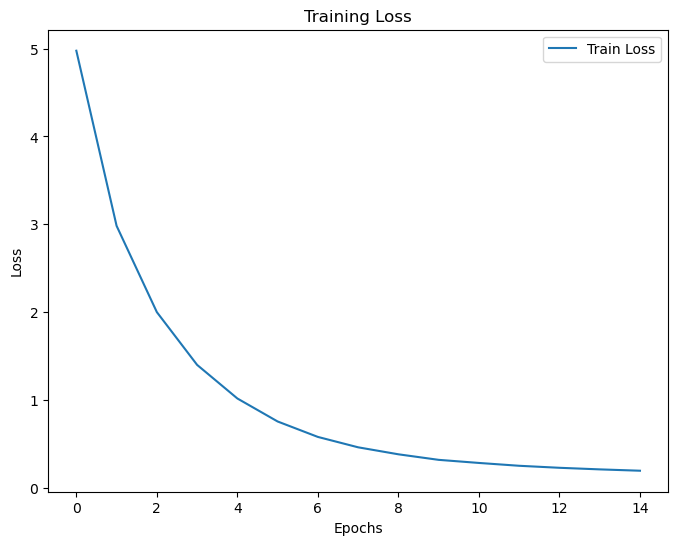

In [11]:
plot_loss(history) 

**Zonder convolutionele laag:**
  
De loss begint rond de 6 en daalt langzaam naar ongeveer 2.8 na 15 epochs.
Dit betekent dat het model in het begin slecht presteert en langzaam beter wordt, maar de verbetering is vrij langzaam.

![alt text](image.png)


**Bron en uitleg**

Volgens Jorgecardete. (2024, February 17). Convolutional Neural Networks: A Comprehensive guide. Medium. https://medium.com/thedeephub/convolutional-neural-networks-a-comprehensive-guide-5cc0b5eae175 helpen convolutionele lagen (CNN's) bij het herkennen van lokale patronenn in data. Hierdoor kunnen ze features extraheren die relevant zijn voor het taak-specifieke leren, wat vaak leidt tot betere prestaties en snellere convergentie van het model.

**Hoe werkt tekstgeneratie met ons Mamba model?**

Het proces begint met het startwoord dat we willen gebruiken. Dit woord wordt eerst omgezet naar een nummer dat het model kan begrijpen (token). Als het woord niet voorkomt in het woordenboek dat het model kent, dan kan het proces niet verder en stopt het.

Vervolgens wordt het interne geheugen van het model voorbereid. Dit geheugen houdt bij wat het model tot nu toe heeft geleerd en begint leeg. Het model gebruikt dit geheugen om samenhang te houden tussen de woorden die het genereert.

Voor elk woord dat we willen maken, vraagt het model aan zichzelf: "Wat is het meest logische volgende woord?" Het gebruikt hiervoor het huidige woord en zijn interne geheugen. Als antwoord geeft het model scores voor alle mogelijke woorden in zijn woordenboek.

De temperatuur-parameter bepaalt hoeveel risico het model neemt bij het kiezen van woorden. Bij een lage temperatuur kiest het model vaak de veiligste, meest voorspelbare woorden. Bij een hoge temperatuur durft het model meer te experimenteren en kiest het soms verrassende woorden, wat de tekst creatiever kan maken.

De scores worden omgezet naar kansen en daaruit wordt een woord gekozen. Dit gekozen woord wordt toegevoegd aan de zin en het proces herhaalt zich tot we genoeg woorden hebben. Uiteindelijk worden alle gegenereerde woorden aan elkaar geplakt tot één complete zin die het model als output geeft.

In [12]:
def generate(model, start_word, word2idx, idx2word, num_words=50, temperature=1.0):
    """Genereert tekst met het Mamba-model."""
    model.trainable = False # Zet model in inference mode
    
    # Verander het startwoord naar een token
    current_word = start_word.lower()
    if current_word not in word2idx:
        print(f"Woord '{current_word}' niet in woordenboek. Kies een ander woord.")
        return ""
        
    token = word2idx[current_word]
    generated = [current_word]
    
    # Initialiseer de verborgen staat (h)
    # De shape is (batch_size, state_dim), dus (1, 16)
    h = tf.zeros([1, model.A_log.shape[0]], dtype=tf.float32)

    for _ in range(num_words - 1):
        # De input voor het model moet een batch zijn, dus (batch_size, seq_length) -> (1, 1)
        input_tensor = tf.constant([[token]], dtype=tf.int32)
        
        # Roep het model aan met de huidige staat om de logits en de volgende staat te krijgen
        logits, h = model(input_tensor, initial_state=h)
        
        # Haal de logits voor de laatste tijdstap eruit en verwijder de sequence-dimensie
        # Shape van logits is (1, 1, vocab_size), na squeeze is het (1, vocab_size)
        logits = tf.squeeze(logits, axis=1)
        
        logits /= temperature
        
        # Bereken kansen met softmax
        probabilities = tf.nn.softmax(logits)
        
        # Sample de volgende token op basis van de kansen
        token = tf.random.categorical(tf.math.log(probabilities), num_samples=1)[0, 0].numpy()
        
        # Voeg het gegenereerde woord toe aan de lijst
        word = idx2word[token]
        generated.append(word)

    return ' '.join(generated)

In [23]:
# Genereer tekst met het model
start_word = "bitch"
generated_text = generate(model, start_word, word2idx, idx2word, num_words=30, temperature=0.8)
print("Output: ", generated_text)

Output:  bitch call that yall at nittdagritt suggest mobbing 33 smoked suggest bulls imature bulls imature bulls bulls imature bulls imature imature spot spot imature spot gunning imature bulls imature bulls


## De outputs - Zonder convolution blok
`Output:  yeah and he mad and shit im a boss only one i got my money ayy if youre with him`

`Output:  bang baaang already go out on you tryna chill with you baby i know youre with him now but soon`

`Output:  car gettin fly gotta go and shit and he deserves to my drug what you wanna say put that you`

`Output:  trap disrespecting my nieces and watch cause we gon need you from you ride and seven mansions boy you know its hit my team 1738 squad and youll be fine`

`Output:  bitch can dumpin you after i swear she get your boo take it wwatch the trap a dream so up catch me see myself in the city ima take it`

## De outputs - Met convolution blok
`Output: yeah puttin his looks bomb imature spot bulls bulls imature bulls wobbling ready new car ohohoh sister celluar threats heavyweight`

`Output:  bang baaang scoring left bae every brand beans candles amazing roll zillion imature suggest imature spot imature spot ready whenever`

`Output:  car every bet whatever sister skateboard lick spot imature bulls bulls imature bulls bulls imature imature bulls imature imature imature`

`Output:  trap range summer hotter than cribs wouldve ready suggest choose fresh imature bulls imature imature ready new scoring left eye across imature bulls imature bulls bulls laurent bulls bulls imature`

`Output:  bitch call that yall at nittdagritt suggest mobbing 33 smoked suggest bulls imature bulls imature bulls bulls imature bulls imature imature spot spot imature spot gunning imature bulls imature bulls`


---
<div style="background-color:lightblue; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> H6: Conclusie </strong></h2>

</ul>

In dit project hebben we een Mamba model met HiPPO gemaakt voor het genereren van rap lyrics. We hebben hierbij ook gekeken naar de invloed van een convolutionele laag.

Onze verschillende manieren toonden een groot verschil tussen de twee modelvarianten. Het model met een convolutionele laag leerde veel sneller, met een loss die daalde van ongeveer 5 naar 0.2 in 15 epochs. Het model zonder convolutionele laag had meer moeite, waarbij de loss langzamer daalde van 6 naar 2.8. Dit bevestigt wat we al wisten uit de literatuur: convolutionele lagen helpen bij het herkennen van lokale patronen in tekst, waardoor het model beter kan leren.

Maar, toen we naar de gegenereerde tekst keken, zagen we wat anders. Het model met convolutionele laag produceerde vaak repetitieve woorden zoals "imature bulls" en "spot", wat liet zien dat het misschien te veel focus legt op bepaalde patronen. Het model zonder convolutionele laag genereerde juist meer gevarieerde en natuurlijk klinkende rap lyrics, zoals "yeah and he mad and shit im a boss only one i got my money" dit klinkt meer als een echte rap tekst.

Dus een lagere loss betekent niet automatisch betere tekstkwaliteit. Het model met convolutionele laag heeft weliswaar beter geleerd om de training data te voorspellen, maar lijkt minder goed in het genereren van creatieve en gevarieerde tekst. Het model zonder convolutionele laag genereert tekst die natuurlijker klinkt voor rap music.

Tijdens dit project hebben wij erg veel moeite gehad met het implementeren van Mamba en HiPPO, omdat dit voor ons een nieuwe techniek is waar niet veel over bekend is. Dit heeft wel laten zien dat Mamba modellen geschikt zijn voor tekstgeneratie, maar dat de architectuurkeuzes een grote invloed hebben op zowel de leersnelheid als de kwaliteit van de output.


---
<div style="background-color:lightblue; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> H7: Bronnen </strong></h2>

</ul>

* ChatGPT. (2025, March). Prompt 1: Hoe zou jij een mamba… [https://chatgpt.com/share/67df010c-c968-8013-8bbc-f9f92fe51fa1](https://chatgpt.com/share/67df010c-c968-8013-8bbc-f9f92fe51fa1)

* ChatGPT. (2025, March). Prompt 2: Ik wil dat je in de class functie… [https://chatgpt.com/share/67df010c-c968-8013-8bbc-f9f92fe51fa1](https://chatgpt.com/share/67df010c-c968-8013-8bbc-f9f92fe51fa1)

* ChatGPT. (2025, March). Prompt 3: Verschillende evaluatiemethoden… [https://chatgpt.com/share/67d810f7-186c-800d-a276-be1ce07f6731](https://chatgpt.com/share/67d810f7-186c-800d-a276-be1ce07f6731)

* ChatGPT. (2025, June 28). Prompt 4: Wordt hier HiPPO gebruikt… [https://chatgpt.com/share/685fe1bf-83c4-8013-bb03-b9535fdb6772](https://chatgpt.com/share/685fe1bf-83c4-8013-bb03-b9535fdb6772)

* Gemini. (2025, June). Prompt: Is model gebaseerd op het paper? [https://gemini.google.com/share/7d1a8b4511f9](https://gemini.google.com/share/7d1a8b4511f9)

* GeeksforGeeks. (2021a, May 18). Tensorflow\.js TF.MatMul() function. GeeksforGeeks. [https://www.geeksforgeeks.org/tensorflow-js-tf-matmul-function/](https://www.geeksforgeeks.org/tensorflow-js-tf-matmul-function/)

* GeeksforGeeks. (2021b, May 18). Tensorflow\.js tf.randomUniform() function. GeeksforGeeks. [https://www.geeksforgeeks.org/tensorflow-js-tf-randomuniform-function/](https://www.geeksforgeeks.org/tensorflow-js-tf-randomuniform-function/)

* GeeksforGeeks. (2021c, December 12). Python | TensorFlow nn.sigmoid(). GeeksforGeeks. [https://www.geeksforgeeks.org/python-tensorflow-nn-sigmoid/](https://www.geeksforgeeks.org/python-tensorflow-nn-sigmoid/)

* GeeksforGeeks. (2021d, December 13). Python | TensorFlow log() method. GeeksforGeeks. [https://www.geeksforgeeks.org/python-tensorflow-log-method/](https://www.geeksforgeeks.org/python-tensorflow-log-method/)

* Gu, A., & Dao, T. (2023). Mamba: Linear‑time sequence modeling with selective state spaces. arXiv. [https://arxiv.org/abs/2305.17924](https://arxiv.org/abs/2305.17924)

* Grootendorst, M. (n.d.). A visual guide to Mamba and state space models. [https://www.maartengrootendorst.com/blog/mamba/](https://www.maartengrootendorst.com/blog/mamba/)

* Stack Overflow. (n.d.). What does tf.nn.embedding\_lookup function do? Retrieved June 30, 2025, from [https://stackoverflow.com/questions/34870614/what-does-tf-nn-embedding-lookup-function-do](https://stackoverflow.com/questions/34870614/what-does-tf-nn-embedding-lookup-function-do)

* TensorFlow. (n.d.). Introduction to variables. [https://www.tensorflow.org/guide/variable](https://www.tensorflow.org/guide/variable)

* TensorFlow. (n.d.). tf.zeros. [https://www.tensorflow.org/api\_docs/python/tf/zeros](https://www.tensorflow.org/api_docs/python/tf/zeros)

* TensorFlow. (n.d.). tf.random.categorical. [https://www.tensorflow.org/api\_docs/python/tf/random/categorical](https://www.tensorflow.org/api_docs/python/tf/random/categorical)

* TensorFlow. (n.d.). Writing a training loop from scratch. [https://www.tensorflow.org/guide/keras/writing\_a\_training\_loop\_from\_scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)

* TheDeepHub. (n.d.). Convolutional neural networks: A comprehensive guide. Medium. [https://medium.com/thedeephub/convolutional-neural-networks-a-comprehensive-guide-5cc0b5eae175](https://medium.com/thedeephub/convolutional-neural-networks-a-comprehensive-guide-5cc0b5eae175)

* Welsh, J. (n.d.). Rap lyrics \[Data set]. Kaggle. [https://www.kaggle.com/datasets/jamiewelsh2/rap-lyrics](https://www.kaggle.com/datasets/jamiewelsh2/rap-lyrics)
